In [46]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [47]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

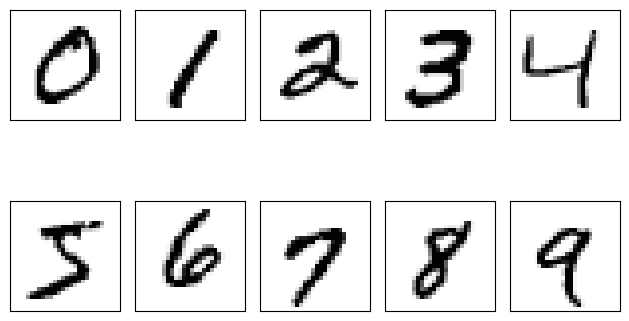

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

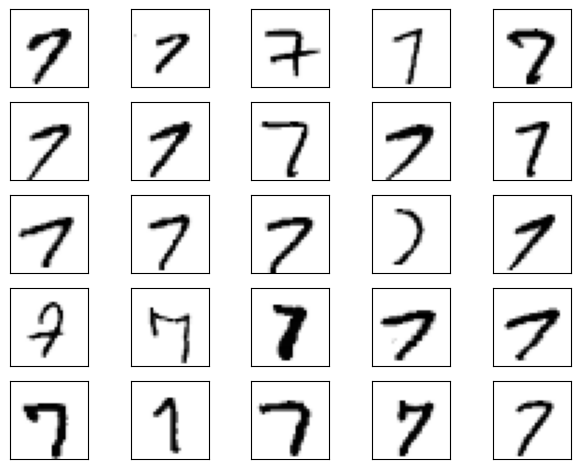

In [49]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [50]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

# Implementing a multi-layer perceptron

In [51]:
import numpy as np

In [52]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))
    # return np.where(z >= 0,
    #                 1 / (1 + np.exp(-z)),
    #                 np.exp(z) / (1 + np.exp(z)))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary


class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [53]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=500,
                     num_classes=10)

# Coding the neural network training loop

Defining data loaders:

In [54]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:
        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [55]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 10.5%


In [56]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [57]:
from sklearn.metrics import roc_auc_score
import numpy as np

def row_normalize_probas(probas, eps=1e-12):
    """Ensure rows sum to 1 (required by sklearn's multiclass roc_auc_score)."""
    row_sums = probas.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums <= eps, eps, row_sums)
    return probas / row_sums

def compute_macro_auc(nnet, X, y, minibatch_size=100, eps=1e-12):
    """
    Computes the Macro-averaged Area Under the ROC Curve.
    """
    all_probas = []
    all_targets = []

    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for features, targets in minibatch_gen:
        _, probas = nnet.forward(features)
        all_probas.append(probas)
        all_targets.append(targets)

    y_true_combined = np.concatenate(all_targets)
    y_probas_combined = np.concatenate(all_probas)

    y_probas_combined = row_normalize_probas(y_probas_combined, eps)

    macro_auc = roc_auc_score(y_true_combined, y_probas_combined, multi_class='ovr', average='macro')
    return macro_auc

In [58]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
auc = compute_macro_auc(model, X_valid, y_valid)

print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')
print(f'Initial valid Macro AUC: {auc:.3f}')

Initial valid MSE: 0.2
Initial valid accuracy: 10.5%
Initial valid Macro AUC: 0.481


In [59]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        valid_auc = compute_macro_auc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%'
              f'| Valid AUC: {valid_auc:.3f}')


    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [60]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.03 | Train Acc: 85.10% | Valid Acc: 84.92%| Valid AUC: 0.979
Epoch: 002/050 | Train MSE: 0.02 | Train Acc: 87.83% | Valid Acc: 87.59%| Valid AUC: 0.984
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 89.35% | Valid Acc: 89.05%| Valid AUC: 0.985
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 90.08% | Valid Acc: 89.88%| Valid AUC: 0.987
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.69% | Valid Acc: 90.25%| Valid AUC: 0.988
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.99% | Valid Acc: 90.59%| Valid AUC: 0.988
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.49% | Valid Acc: 91.10%| Valid AUC: 0.989
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.95% | Valid Acc: 91.43%| Valid AUC: 0.989
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 92.15% | Valid Acc: 91.53%| Valid AUC: 0.990
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.50% | Valid Acc: 91.82%| Valid AUC: 0.990
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.59% | Valid Acc: 91.90%| Valid AUC: 0.990

# Evaluating the neural network performance

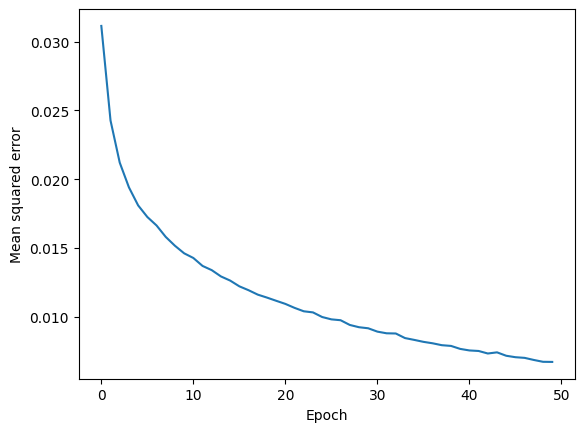

In [61]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

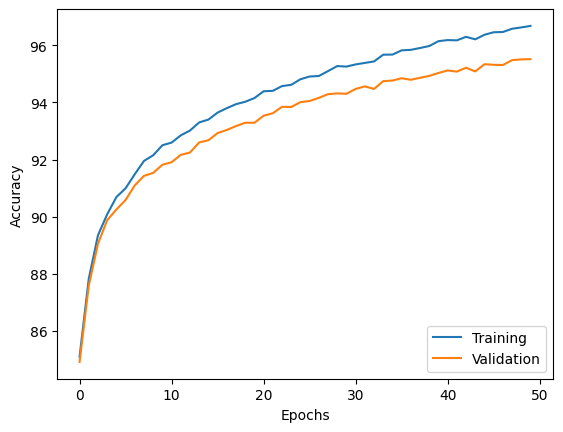

In [62]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [63]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
test_auc = compute_macro_auc(model, X_test, y_test)

print(f'Test MSE: {test_mse:.2f}')
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test Macro AUC: {test_auc:.4f}')

Test MSE: 0.01
Test accuracy: 95.66%
Test Macro AUC: 0.9961


Plot failure cases:

In [64]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

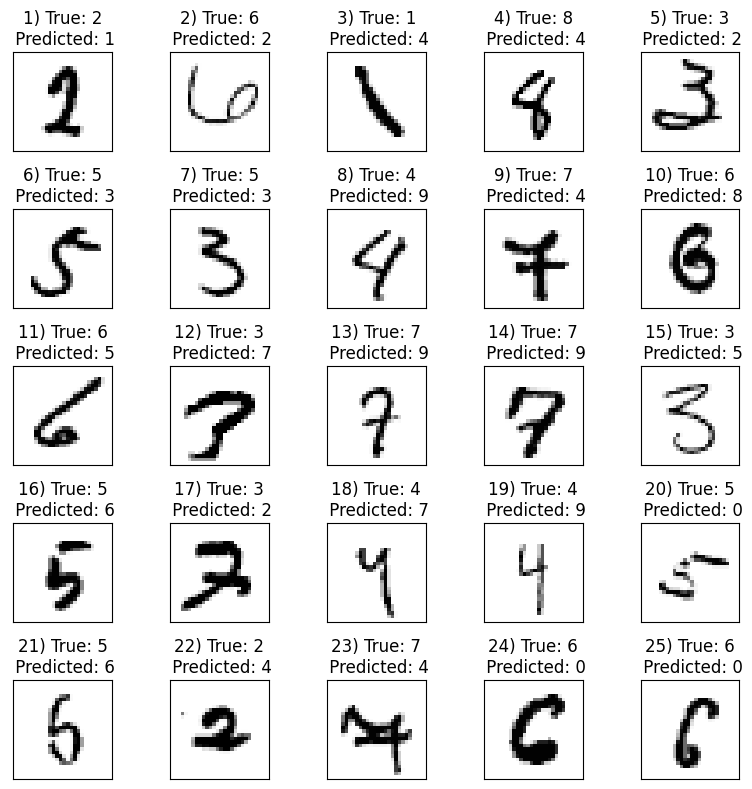

In [65]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

# Task 2: NeuralNetMLP with 2 Hidden Layers

In [66]:
import numpy as np
import sys
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

# ==========================================
# Task 1 & 2: NeuralNetMLP with 2 Hidden Layers
# ==========================================
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def sigmoid_clip(z):
    # Clip z to prevent exp(z) from overflowing
    z = np.clip(z, -500, 500)
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

class NeuralNetMLP_2Layers:
    """MLP classifier with TWO hidden layers (scratch implementation)."""

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden1
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h = np.zeros(num_hidden1)

        # hidden2
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid_clip(z_h)

        # Hidden layer 2
        # input dim: [n_examples, n_hidden1] dot [n_hidden2, n_hidden1].T
        # output dim: [n_examples, n_hidden2]
        z_h2 = np.dot(a_h, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid_clip(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = softmax(z_out)
        return (a_h, a_h2), a_out

    def backward(self, x, a_h, a_h2, a_out, y):
        n = x.shape[0]
        y_onehot = int_to_onehot(y, self.num_classes)

        # dL/dP
        dL_dP = (2.0 / (n * self.num_classes)) * (a_out - y_onehot)  # shape [n, C]

        # dP/dZ for softmax: J = diag(p) - p p^T
        # Efficient vectorized: dZ = p * (dP - sum(dP*p))
        dot = np.sum(dL_dP * a_out, axis=1, keepdims=True)          # [n, 1]
        dZ = a_out * (dL_dP - dot)                                  # [n, C]

        # Output layer grads
        d_w_out = np.dot(dZ.T, a_h2)                                # [C, H2]
        d_b_out = np.sum(dZ, axis=0)                                # [C]

        # Backprop into hidden2
        dA2 = np.dot(dZ, self.weight_out)                           # [n, H2]
        dZ2 = dA2 * a_h2 * (1 - a_h2)                               # sigmoid'
        d_w_h2 = np.dot(dZ2.T, a_h)                                 # [H2, H1]
        d_b_h2 = np.sum(dZ2, axis=0)                                # [H2]

        # Backprop into hidden1
        dA1 = np.dot(dZ2, self.weight_h2)                           # [n, H1]
        dZ1 = dA1 * a_h * (1 - a_h)                                 # sigmoid'
        d_w_h = np.dot(dZ1.T, x)                                    # [H1, D]
        d_b_h = np.sum(dZ1, axis=0)                                 # [H1]

        return d_w_h, d_b_h, d_w_h2, d_b_h2, d_w_out, d_b_out

    def predict_probas(self, X, minibatch_size=100):
        probas_list = []
        for X_mini, _ in minibatch_generator(X, np.zeros(X.shape[0], dtype=int), minibatch_size):
            _, probas = self.forward(X_mini)
            probas_list.append(probas)
        return np.vstack(probas_list)

    def predict(self, X, minibatch_size=100):
        probas = self.predict_probas(X, minibatch_size=minibatch_size)
        return np.argmax(probas, axis=1)

In [67]:
def train_2hl(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1, minibatch_size=100):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # Iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            (a_h, a_h2), a_out = model.forward(X_train_mini)

            d_w_h, d_b_h, d_w_h2, d_b_h2, d_w_out, d_b_out = model.backward(
                X_train_mini, a_h, a_h2, a_out, y_train_mini
            )

            #### Update weights ####
            # 1. Update Hidden Layer 1
            model.weight_h   -= learning_rate * d_w_h
            model.bias_h     -= learning_rate * d_b_h

            # 2. Update Hidden Layer 2
            model.weight_h2  -= learning_rate * d_w_h2
            model.bias_h2    -= learning_rate * d_b_h2

            # 3. Update Output Layer
            model.weight_out -= learning_rate * d_w_out
            model.bias_out   -= learning_rate * d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(
            model, X_train, y_train, num_labels=model.num_classes,
            minibatch_size=minibatch_size
            )
        valid_mse, valid_acc = compute_mse_and_acc(
            model, X_valid, y_valid, num_labels=model.num_classes,
            minibatch_size=minibatch_size
            )
        train_acc, valid_acc = train_acc*100, valid_acc*100

        train_auc = compute_macro_auc(model, X_train, y_train)
        valid_auc = compute_macro_auc(model, X_valid, y_valid)

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f}'
              f'| Train Acc: {train_acc:.2f}% '
              f'| Train AUC: {valid_auc:.3f} '
              f'| Valid MSE: {valid_mse:.2f} '
              f'| Valid Acc: {valid_acc:.2f}% '
              f'| Valid AUC: {valid_auc:.3f}')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [68]:
# ==========================================
# Train and Evaluate
# ==========================================

print("\nTraining Custom 2-Layer MLP...")
model_2layer = NeuralNetMLP_2Layers(
    num_features=28*28,
    num_hidden1=500,
    num_hidden2=500,
    num_classes=10,
    random_seed=123
)

epoch_loss_2layer, epoch_train_acc_2layer, epoch_valid_acc_2layer = train_2hl(
    model_2layer, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=0.1, minibatch_size=minibatch_size
)


Training Custom 2-Layer MLP...
Epoch: 001/050 | Train MSE: 0.08| Train Acc: 29.95% | Train AUC: 0.790 | Valid MSE: 0.08 | Valid Acc: 30.28% | Valid AUC: 0.790
Epoch: 002/050 | Train MSE: 0.08| Train Acc: 42.57% | Train AUC: 0.896 | Valid MSE: 0.08 | Valid Acc: 43.37% | Valid AUC: 0.896
Epoch: 003/050 | Train MSE: 0.07| Train Acc: 56.54% | Train AUC: 0.935 | Valid MSE: 0.07 | Valid Acc: 57.18% | Valid AUC: 0.935
Epoch: 004/050 | Train MSE: 0.06| Train Acc: 65.56% | Train AUC: 0.952 | Valid MSE: 0.06 | Valid Acc: 65.92% | Valid AUC: 0.952
Epoch: 005/050 | Train MSE: 0.05| Train Acc: 72.50% | Train AUC: 0.963 | Valid MSE: 0.05 | Valid Acc: 72.79% | Valid AUC: 0.963
Epoch: 006/050 | Train MSE: 0.05| Train Acc: 74.75% | Train AUC: 0.970 | Valid MSE: 0.05 | Valid Acc: 75.30% | Valid AUC: 0.970
Epoch: 007/050 | Train MSE: 0.04| Train Acc: 78.64% | Train AUC: 0.974 | Valid MSE: 0.04 | Valid Acc: 78.63% | Valid AUC: 0.974
Epoch: 008/050 | Train MSE: 0.04| Train Acc: 81.37% | Train AUC: 0.977 |

In [81]:
# 5. Evaluation (Macro AUC)
print("Evaluating 2 Layers Model...")
y_probs_2layer = model_2layer.predict_probas(X_test, minibatch_size=100)
y_pred_2layer = np.argmax(y_probs_2layer, axis=1)

test_mse_2layer, test_acc_2layer = compute_mse_and_acc(model_2layer, X_test, y_test)
test_auc_2layer = compute_macro_auc(model_2layer, X_test, y_test)

print(f'Test MSE: {test_mse_2layer:.2f}')
print(f'Test accuracy: {test_acc_2layer*100:.2f}%')
print(f'Test Macro AUC: {test_auc_2layer:.4f}')

Evaluating 2 Layers Model...
Test MSE: 0.01
Test accuracy: 91.08%
Test Macro AUC: 0.9915


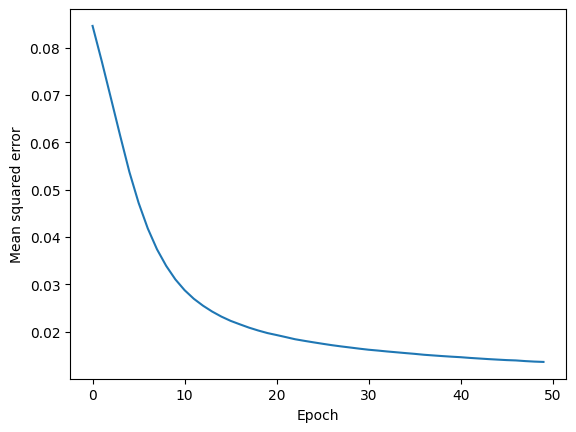

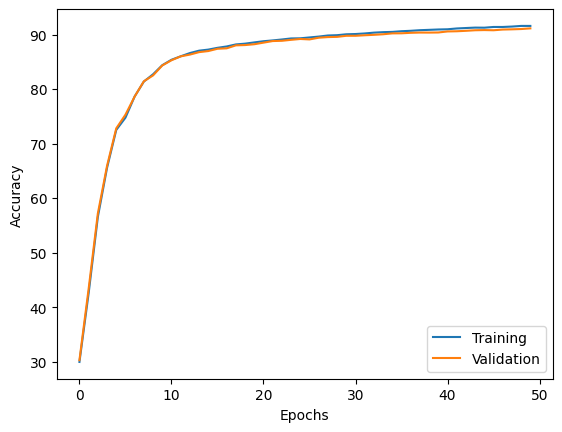

In [70]:
plt.plot(range(len(epoch_loss_2layer)), epoch_loss_2layer)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

plt.plot(range(len(epoch_train_acc_2layer)), epoch_train_acc_2layer,
         label='Training')
plt.plot(range(len(epoch_valid_acc_2layer)), epoch_valid_acc_2layer,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

# PyTorch FCNN Model

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

In [72]:
def int_to_onehot_np(y, num_classes=10):
    y = y.astype(int)
    onehot = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    onehot[np.arange(y.shape[0]), y] = 1.0
    return onehot

def macro_auc_from_scores(y_true_int, y_score, eps=1e-12):
    """
    y_score: (N, C) float scores (sigmoid outputs).
    sklearn multiclass AUC requires rows sum to 1, so we normalize.
    """
    y_score = y_score / (y_score.sum(axis=1, keepdims=True) + eps)
    return roc_auc_score(y_true_int, y_score, multi_class="ovr", average="macro")

In [73]:
@torch.no_grad()
def evaluate_pytorch(model, X_np, y_np, batch_size=256, device="cpu"):
    model.eval()
    ds = TensorDataset(torch.from_numpy(X_np).float(),
                       torch.from_numpy(y_np).long())
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_out = []
    all_y = []
    mse_sum = 0.0
    n_total = 0

    # we'll compute MSE against one-hot targets
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        out = model(xb)  # sigmoid outputs, shape (B, 10)
        y_onehot = torch.zeros((yb.size(0), out.size(1)), device=device)
        y_onehot.scatter_(1, yb.view(-1, 1), 1.0)

        mse_sum += torch.mean((y_onehot - out) ** 2).item() * yb.size(0)
        n_total += yb.size(0)

        all_out.append(out.cpu().numpy())
        all_y.append(yb.cpu().numpy())

    y_score = np.concatenate(all_out, axis=0)
    y_true = np.concatenate(all_y, axis=0)

    y_pred = np.argmax(y_score, axis=1)
    acc = (y_pred == y_true).mean()
    mse = mse_sum / n_total
    auc = macro_auc_from_scores(y_true, y_score)

    return mse, acc, auc

In [74]:
class FCNN(nn.Module):
    def __init__(self, in_dim=784, h1=500, h2=500, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.Sigmoid(),
            nn.Linear(h1, h2),
            nn.Sigmoid(),
            nn.Linear(h2, out_dim),
            nn.Sigmoid(),  # per your assignment screenshot for PyTorch
        )
    def forward(self, x):
        return self.net(x)

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"
fcnn_model = FCNN().to(device)

In [76]:
# MSE loss (with one-hot targets)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(fcnn_model.parameters(), lr=0.1)

In [77]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=500, shuffle=False)

In [78]:
fcnn_train_mse, fcnn_valid_mse = [], []
fcnn_train_acc, fcnn_valid_acc = [], []
fcnn_train_auc, fcnn_valid_auc = [], []

best_state = None
best_valid_auc = -1.0

for epoch in range(num_epochs):
    fcnn_model.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        out = fcnn_model(xb)  # sigmoid outputs

        y_onehot = torch.zeros((yb.size(0), out.size(1)), device=device)
        y_onehot.scatter_(1, yb.view(-1, 1), 1.0)

        loss = criterion(out, y_onehot)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ---- evaluate after each epoch using X_train/X_valid ----
    tr_mse, tr_acc, tr_auc = evaluate_pytorch(fcnn_model, X_train, y_train, batch_size=256, device=device)
    va_mse, va_acc, va_auc = evaluate_pytorch(fcnn_model, X_valid, y_valid, batch_size=256, device=device)

    fcnn_train_mse.append(tr_mse); fcnn_valid_mse.append(va_mse)
    fcnn_train_acc.append(tr_acc); fcnn_valid_acc.append(va_acc)
    fcnn_train_auc.append(tr_auc); fcnn_valid_auc.append(va_auc)

    if va_auc > best_valid_auc:
        best_valid_auc = va_auc
        best_state = {k: v.detach().cpu().clone() for k, v in fcnn_model.state_dict().items()}

    print(f"Epoch {epoch+1:03d}/{num_epochs:03d} | "
          f"Train MSE {tr_mse:.4f} | Acc {tr_acc*100:.2f}% | AUC {tr_auc:.3f} | "
          f"Valid MSE {va_mse:.4f} | Acc {va_acc*100:.2f}% | AUC {va_auc:.3f}")

# restore best
if best_state is not None:
    fcnn_model.load_state_dict(best_state)

Epoch 001/050 | Train MSE 0.0899 | Acc 11.25% | AUC 0.596 | Valid MSE 0.0899 | Acc 11.25% | AUC 0.596
Epoch 002/050 | Train MSE 0.0899 | Acc 11.25% | AUC 0.695 | Valid MSE 0.0899 | Acc 11.25% | AUC 0.696
Epoch 003/050 | Train MSE 0.0899 | Acc 11.25% | AUC 0.766 | Valid MSE 0.0899 | Acc 11.25% | AUC 0.767
Epoch 004/050 | Train MSE 0.0898 | Acc 11.25% | AUC 0.814 | Valid MSE 0.0898 | Acc 11.25% | AUC 0.816
Epoch 005/050 | Train MSE 0.0898 | Acc 11.25% | AUC 0.848 | Valid MSE 0.0898 | Acc 11.25% | AUC 0.849
Epoch 006/050 | Train MSE 0.0897 | Acc 11.25% | AUC 0.872 | Valid MSE 0.0897 | Acc 11.25% | AUC 0.873
Epoch 007/050 | Train MSE 0.0897 | Acc 11.25% | AUC 0.890 | Valid MSE 0.0897 | Acc 11.25% | AUC 0.890
Epoch 008/050 | Train MSE 0.0896 | Acc 11.98% | AUC 0.903 | Valid MSE 0.0896 | Acc 12.05% | AUC 0.903
Epoch 009/050 | Train MSE 0.0896 | Acc 11.25% | AUC 0.912 | Valid MSE 0.0896 | Acc 11.26% | AUC 0.912
Epoch 010/050 | Train MSE 0.0895 | Acc 11.25% | AUC 0.919 | Valid MSE 0.0895 | Acc

In [79]:
# final test
te_mse, te_acc, te_auc = evaluate_pytorch(fcnn_model, X_test, y_test, batch_size=256, device=device)
print("PyTorch FCNN Tset Evaluation:")
print(f'Test MSE: {te_mse:.2f}')
print(f'Test accuracy: {te_acc*100:.2f}%')
print(f'Test Macro AUC: {te_auc:.4f}')

PyTorch FCNN Tset Evaluation:
Test MSE: 0.06
Test accuracy: 62.38%
Test Macro AUC: 0.9472


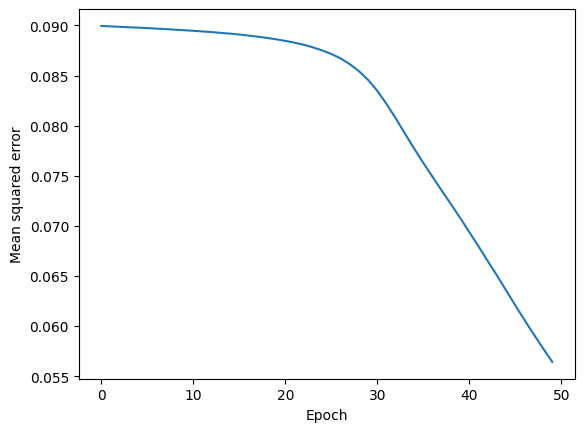

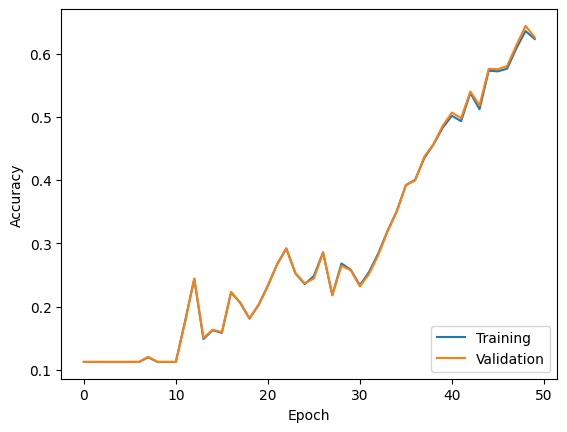

In [80]:
plt.plot(range(len(fcnn_train_mse)), fcnn_train_mse)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

plt.plot(range(len(fcnn_train_acc)), fcnn_train_acc, label='Training')
plt.plot(range(len(fcnn_valid_acc)), fcnn_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()